# Полносвязная Нейронная Сеть

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rd.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

НС - `TwoLayerNet` в `rd/classifiers/neural_net.py`

## Загрузка данных

In [2]:
from rd.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'rd/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Обучение НС

In [3]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.303305
iteration 100 / 1000: loss 2.302871
iteration 200 / 1000: loss 2.296916
iteration 300 / 1000: loss 2.254818
iteration 400 / 1000: loss 2.153301
iteration 500 / 1000: loss 2.129725
iteration 600 / 1000: loss 2.118973
iteration 700 / 1000: loss 2.066045
iteration 800 / 1000: loss 1.968239
iteration 900 / 1000: loss 1.972115
Validation accuracy:  0.293


## Debug

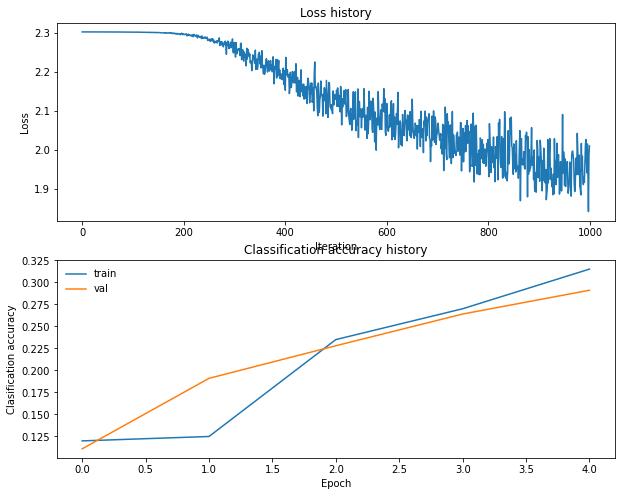

In [4]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(frameon=False)
plt.show()

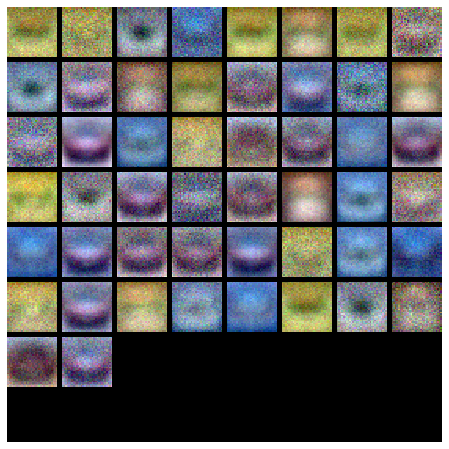

In [5]:
from rd.vis_utils import visualize_grid

# Visualize the weights of the network
def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

## Настройка гиперпараметров

- потери уменьшаются более или менее линейно => скорость обучения может быть слишком низкой
- точностью обучения и проверки => модель имеет низкую емкость и мы должны увеличить ее размер. С другой стороны, с очень большой моделью мы ожидаем увидеть больше переобучения, которое проявится как очень большой разрыв между точностью обучения и проверки.

Тюнинг:
- размер скрытого слоя
- скорость обучения
- количество эпох обучения
- степень регуляризации
- спад скорости обучения

In [6]:
best_net = None # store the best model into this 

input_size = 32 * 32 * 3
num_classes = 10

hidden_sizes = [50, 100, 150, 200]
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
learning_rate_decays = [0.99, 0.95, 0.90, 0.85, 0.8]
regularization_strengths = [0.7, 0.5]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.

for lr in learning_rates:
    for rs in regularization_strengths:
        for hs in hidden_sizes:
            for lrd in learning_rate_decays:
                net = TwoLayerNet(input_size, hs, num_classes)
                stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=2000, batch_size=200,
                    learning_rate=lr, learning_rate_decay=lrd,
                    reg=rs, verbose=True)

                y_train_pred = net.predict(X_train)
                y_val_pred = net.predict(X_val)
                train_accuracy = np.mean(y_train == y_train_pred)
                val_accuracy = np.mean(y_val == y_val_pred)
                if val_accuracy > best_val:
                    best_val = val_accuracy
                    best_net = net

                results[(lr,rs,hs,lrd)] = train_accuracy, val_accuracy
         
for lr, reg, hs,lrd in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hs, lrd)]
    print('lr %e reg %e hs %d lrd %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hs, lrd, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 2.303655
iteration 100 / 2000: loss 1.945337
iteration 200 / 2000: loss 1.746856
iteration 300 / 2000: loss 1.770218
iteration 400 / 2000: loss 1.778958
iteration 500 / 2000: loss 1.613233
iteration 600 / 2000: loss 1.616802
iteration 700 / 2000: loss 1.542024
iteration 800 / 2000: loss 1.614173
iteration 900 / 2000: loss 1.652518
iteration 1000 / 2000: loss 1.648394
iteration 1100 / 2000: loss 1.597256
iteration 1200 / 2000: loss 1.609228
iteration 1300 / 2000: loss 1.639003
iteration 1400 / 2000: loss 1.682885
iteration 1500 / 2000: loss 1.592606
iteration 1600 / 2000: loss 1.565163
iteration 1700 / 2000: loss 1.592080
iteration 1800 / 2000: loss 1.628114
iteration 1900 / 2000: loss 1.650560
iteration 0 / 2000: loss 2.303660
iteration 100 / 2000: loss 1.968973
iteration 200 / 2000: loss 1.801906
iteration 300 / 2000: loss 1.816338
iteration 400 / 2000: loss 1.664569
iteration 500 / 2000: loss 1.788656
iteration 600 / 2000: loss 1.700394
iteration 700 / 2000: 

iteration 600 / 2000: loss 1.729241
iteration 700 / 2000: loss 1.665623
iteration 800 / 2000: loss 1.683398
iteration 900 / 2000: loss 1.466669
iteration 1000 / 2000: loss 1.607981
iteration 1100 / 2000: loss 1.572911
iteration 1200 / 2000: loss 1.608501
iteration 1300 / 2000: loss 1.549554
iteration 1400 / 2000: loss 1.674394
iteration 1500 / 2000: loss 1.400802
iteration 1600 / 2000: loss 1.577736
iteration 1700 / 2000: loss 1.732402
iteration 1800 / 2000: loss 1.550240
iteration 1900 / 2000: loss 1.492813
iteration 0 / 2000: loss 2.305846
iteration 100 / 2000: loss 1.956899
iteration 200 / 2000: loss 1.806738
iteration 300 / 2000: loss 1.726961
iteration 400 / 2000: loss 1.650567
iteration 500 / 2000: loss 1.639621
iteration 600 / 2000: loss 1.556604
iteration 700 / 2000: loss 1.615961
iteration 800 / 2000: loss 1.569934
iteration 900 / 2000: loss 1.631353
iteration 1000 / 2000: loss 1.600565
iteration 1100 / 2000: loss 1.511859
iteration 1200 / 2000: loss 1.692237
iteration 1300 / 

iteration 1200 / 2000: loss 1.518593
iteration 1300 / 2000: loss 1.593290
iteration 1400 / 2000: loss 1.672200
iteration 1500 / 2000: loss 1.439437
iteration 1600 / 2000: loss 1.515281
iteration 1700 / 2000: loss 1.517042
iteration 1800 / 2000: loss 1.536885
iteration 1900 / 2000: loss 1.568738
iteration 0 / 2000: loss 2.303365
iteration 100 / 2000: loss 1.852540
iteration 200 / 2000: loss 1.781792
iteration 300 / 2000: loss 1.761280
iteration 400 / 2000: loss 1.727485
iteration 500 / 2000: loss 1.728645
iteration 600 / 2000: loss 1.643709
iteration 700 / 2000: loss 1.607157
iteration 800 / 2000: loss 1.672360
iteration 900 / 2000: loss 1.517998
iteration 1000 / 2000: loss 1.684332
iteration 1100 / 2000: loss 1.603952
iteration 1200 / 2000: loss 1.762548
iteration 1300 / 2000: loss 1.719141
iteration 1400 / 2000: loss 1.573843
iteration 1500 / 2000: loss 1.495400
iteration 1600 / 2000: loss 1.553938
iteration 1700 / 2000: loss 1.604190
iteration 1800 / 2000: loss 1.504846
iteration 190

iteration 1700 / 2000: loss 1.447505
iteration 1800 / 2000: loss 1.531794
iteration 1900 / 2000: loss 1.494413
iteration 0 / 2000: loss 2.304923
iteration 100 / 2000: loss 1.972495
iteration 200 / 2000: loss 1.877003
iteration 300 / 2000: loss 1.606684
iteration 400 / 2000: loss 1.712574
iteration 500 / 2000: loss 1.689657
iteration 600 / 2000: loss 1.668569
iteration 700 / 2000: loss 1.644641
iteration 800 / 2000: loss 1.435640
iteration 900 / 2000: loss 1.480308
iteration 1000 / 2000: loss 1.630936
iteration 1100 / 2000: loss 1.508632
iteration 1200 / 2000: loss 1.546392
iteration 1300 / 2000: loss 1.497427
iteration 1400 / 2000: loss 1.485865
iteration 1500 / 2000: loss 1.364424
iteration 1600 / 2000: loss 1.445329
iteration 1700 / 2000: loss 1.665138
iteration 1800 / 2000: loss 1.632924
iteration 1900 / 2000: loss 1.489417
iteration 0 / 2000: loss 2.305637
iteration 100 / 2000: loss 1.893909
iteration 200 / 2000: loss 1.865901
iteration 300 / 2000: loss 1.711820
iteration 400 / 200

iteration 300 / 2000: loss 2.252199
iteration 400 / 2000: loss 2.181850
iteration 500 / 2000: loss 2.080715
iteration 600 / 2000: loss 2.079304
iteration 700 / 2000: loss 1.965400
iteration 800 / 2000: loss 1.931765
iteration 900 / 2000: loss 1.942904
iteration 1000 / 2000: loss 1.917267
iteration 1100 / 2000: loss 1.920592
iteration 1200 / 2000: loss 1.853945
iteration 1300 / 2000: loss 1.942712
iteration 1400 / 2000: loss 1.824907
iteration 1500 / 2000: loss 1.845946
iteration 1600 / 2000: loss 1.755864
iteration 1700 / 2000: loss 1.868145
iteration 1800 / 2000: loss 1.852181
iteration 1900 / 2000: loss 1.736168
iteration 0 / 2000: loss 2.304741
iteration 100 / 2000: loss 2.303952
iteration 200 / 2000: loss 2.296096
iteration 300 / 2000: loss 2.251310
iteration 400 / 2000: loss 2.204574
iteration 500 / 2000: loss 2.110051
iteration 600 / 2000: loss 2.048849
iteration 700 / 2000: loss 2.059666
iteration 800 / 2000: loss 2.089773
iteration 900 / 2000: loss 2.042816
iteration 1000 / 200

iteration 900 / 2000: loss 1.935501
iteration 1000 / 2000: loss 1.919245
iteration 1100 / 2000: loss 1.864043
iteration 1200 / 2000: loss 1.846464
iteration 1300 / 2000: loss 1.928204
iteration 1400 / 2000: loss 1.806953
iteration 1500 / 2000: loss 1.871268
iteration 1600 / 2000: loss 1.852584
iteration 1700 / 2000: loss 1.791960
iteration 1800 / 2000: loss 1.805048
iteration 1900 / 2000: loss 1.811089
iteration 0 / 2000: loss 2.306924
iteration 100 / 2000: loss 2.304996
iteration 200 / 2000: loss 2.290902
iteration 300 / 2000: loss 2.244924
iteration 400 / 2000: loss 2.128645
iteration 500 / 2000: loss 2.118461
iteration 600 / 2000: loss 2.093827
iteration 700 / 2000: loss 2.074469
iteration 800 / 2000: loss 2.044408
iteration 900 / 2000: loss 1.975815
iteration 1000 / 2000: loss 1.949937
iteration 1100 / 2000: loss 1.959976
iteration 1200 / 2000: loss 1.912432
iteration 1300 / 2000: loss 1.824544
iteration 1400 / 2000: loss 1.885865
iteration 1500 / 2000: loss 1.894203
iteration 1600

iteration 1500 / 2000: loss 1.880633
iteration 1600 / 2000: loss 1.937521
iteration 1700 / 2000: loss 1.844534
iteration 1800 / 2000: loss 1.746000
iteration 1900 / 2000: loss 1.863675
iteration 0 / 2000: loss 2.304086
iteration 100 / 2000: loss 2.303615
iteration 200 / 2000: loss 2.297907
iteration 300 / 2000: loss 2.268167
iteration 400 / 2000: loss 2.210177
iteration 500 / 2000: loss 2.154691
iteration 600 / 2000: loss 2.125126
iteration 700 / 2000: loss 2.095741
iteration 800 / 2000: loss 2.086328
iteration 900 / 2000: loss 2.000805
iteration 1000 / 2000: loss 2.017655
iteration 1100 / 2000: loss 2.023711
iteration 1200 / 2000: loss 2.044894
iteration 1300 / 2000: loss 2.009414
iteration 1400 / 2000: loss 2.044242
iteration 1500 / 2000: loss 1.925312
iteration 1600 / 2000: loss 1.985235
iteration 1700 / 2000: loss 1.931540
iteration 1800 / 2000: loss 1.962590
iteration 1900 / 2000: loss 1.873020
iteration 0 / 2000: loss 2.304110
iteration 100 / 2000: loss 2.303485
iteration 200 / 2

iteration 0 / 2000: loss 2.305622
iteration 100 / 2000: loss 2.304330
iteration 200 / 2000: loss 2.296927
iteration 300 / 2000: loss 2.261559
iteration 400 / 2000: loss 2.204145
iteration 500 / 2000: loss 2.175773
iteration 600 / 2000: loss 2.117559
iteration 700 / 2000: loss 2.094057
iteration 800 / 2000: loss 2.041301
iteration 900 / 2000: loss 1.997000
iteration 1000 / 2000: loss 2.032287
iteration 1100 / 2000: loss 1.999482
iteration 1200 / 2000: loss 1.997310
iteration 1300 / 2000: loss 2.053879
iteration 1400 / 2000: loss 1.962399
iteration 1500 / 2000: loss 1.969587
iteration 1600 / 2000: loss 2.038586
iteration 1700 / 2000: loss 1.978185
iteration 1800 / 2000: loss 1.917756
iteration 1900 / 2000: loss 1.884943
iteration 0 / 2000: loss 2.303638
iteration 100 / 2000: loss 2.303637
iteration 200 / 2000: loss 2.303622
iteration 300 / 2000: loss 2.303593
iteration 400 / 2000: loss 2.303531
iteration 500 / 2000: loss 2.303528
iteration 600 / 2000: loss 2.303480
iteration 700 / 2000: 

iteration 600 / 2000: loss 2.305267
iteration 700 / 2000: loss 2.304979
iteration 800 / 2000: loss 2.305104
iteration 900 / 2000: loss 2.304896
iteration 1000 / 2000: loss 2.304453
iteration 1100 / 2000: loss 2.304182
iteration 1200 / 2000: loss 2.304056
iteration 1300 / 2000: loss 2.303024
iteration 1400 / 2000: loss 2.301658
iteration 1500 / 2000: loss 2.301072
iteration 1600 / 2000: loss 2.299055
iteration 1700 / 2000: loss 2.299041
iteration 1800 / 2000: loss 2.297318
iteration 1900 / 2000: loss 2.295363
iteration 0 / 2000: loss 2.305843
iteration 100 / 2000: loss 2.305766
iteration 200 / 2000: loss 2.305764
iteration 300 / 2000: loss 2.305642
iteration 400 / 2000: loss 2.305548
iteration 500 / 2000: loss 2.305472
iteration 600 / 2000: loss 2.305439
iteration 700 / 2000: loss 2.305217
iteration 800 / 2000: loss 2.305207
iteration 900 / 2000: loss 2.304974
iteration 1000 / 2000: loss 2.304854
iteration 1100 / 2000: loss 2.304945
iteration 1200 / 2000: loss 2.304512
iteration 1300 / 

iteration 1200 / 2000: loss 2.302494
iteration 1300 / 2000: loss 2.302434
iteration 1400 / 2000: loss 2.302403
iteration 1500 / 2000: loss 2.301635
iteration 1600 / 2000: loss 2.301674
iteration 1700 / 2000: loss 2.301488
iteration 1800 / 2000: loss 2.301840
iteration 1900 / 2000: loss 2.300618
iteration 0 / 2000: loss 2.303373
iteration 100 / 2000: loss 2.303339
iteration 200 / 2000: loss 2.303325
iteration 300 / 2000: loss 2.303262
iteration 400 / 2000: loss 2.303251
iteration 500 / 2000: loss 2.303273
iteration 600 / 2000: loss 2.303237
iteration 700 / 2000: loss 2.303203
iteration 800 / 2000: loss 2.303078
iteration 900 / 2000: loss 2.303131
iteration 1000 / 2000: loss 2.302988
iteration 1100 / 2000: loss 2.303074
iteration 1200 / 2000: loss 2.303013
iteration 1300 / 2000: loss 2.302878
iteration 1400 / 2000: loss 2.302695
iteration 1500 / 2000: loss 2.302823
iteration 1600 / 2000: loss 2.302664
iteration 1700 / 2000: loss 2.302685
iteration 1800 / 2000: loss 2.302081
iteration 190

iteration 1700 / 2000: loss 2.303139
iteration 1800 / 2000: loss 2.302678
iteration 1900 / 2000: loss 2.303027
iteration 0 / 2000: loss 2.304919
iteration 100 / 2000: loss 2.304819
iteration 200 / 2000: loss 2.304815
iteration 300 / 2000: loss 2.304830
iteration 400 / 2000: loss 2.304724
iteration 500 / 2000: loss 2.304586
iteration 600 / 2000: loss 2.304525
iteration 700 / 2000: loss 2.304473
iteration 800 / 2000: loss 2.304436
iteration 900 / 2000: loss 2.304308
iteration 1000 / 2000: loss 2.304278
iteration 1100 / 2000: loss 2.304031
iteration 1200 / 2000: loss 2.304174
iteration 1300 / 2000: loss 2.304037
iteration 1400 / 2000: loss 2.303993
iteration 1500 / 2000: loss 2.303727
iteration 1600 / 2000: loss 2.303949
iteration 1700 / 2000: loss 2.303676
iteration 1800 / 2000: loss 2.303546
iteration 1900 / 2000: loss 2.303514
iteration 0 / 2000: loss 2.304853
iteration 100 / 2000: loss 2.304831
iteration 200 / 2000: loss 2.304744
iteration 300 / 2000: loss 2.304717
iteration 400 / 200

iteration 300 / 2000: loss 2.303638
iteration 400 / 2000: loss 2.303634
iteration 500 / 2000: loss 2.303654
iteration 600 / 2000: loss 2.303653
iteration 700 / 2000: loss 2.303651
iteration 800 / 2000: loss 2.303651
iteration 900 / 2000: loss 2.303660
iteration 1000 / 2000: loss 2.303637
iteration 1100 / 2000: loss 2.303662
iteration 1200 / 2000: loss 2.303640
iteration 1300 / 2000: loss 2.303656
iteration 1400 / 2000: loss 2.303642
iteration 1500 / 2000: loss 2.303633
iteration 1600 / 2000: loss 2.303634
iteration 1700 / 2000: loss 2.303634
iteration 1800 / 2000: loss 2.303653
iteration 1900 / 2000: loss 2.303647
iteration 0 / 2000: loss 2.304739
iteration 100 / 2000: loss 2.304725
iteration 200 / 2000: loss 2.304693
iteration 300 / 2000: loss 2.304711
iteration 400 / 2000: loss 2.304702
iteration 500 / 2000: loss 2.304692
iteration 600 / 2000: loss 2.304703
iteration 700 / 2000: loss 2.304699
iteration 800 / 2000: loss 2.304695
iteration 900 / 2000: loss 2.304695
iteration 1000 / 200

iteration 900 / 2000: loss 2.306854
iteration 1000 / 2000: loss 2.306820
iteration 1100 / 2000: loss 2.306820
iteration 1200 / 2000: loss 2.306799
iteration 1300 / 2000: loss 2.306781
iteration 1400 / 2000: loss 2.306790
iteration 1500 / 2000: loss 2.306773
iteration 1600 / 2000: loss 2.306769
iteration 1700 / 2000: loss 2.306710
iteration 1800 / 2000: loss 2.306766
iteration 1900 / 2000: loss 2.306745
iteration 0 / 2000: loss 2.306903
iteration 100 / 2000: loss 2.306825
iteration 200 / 2000: loss 2.306879
iteration 300 / 2000: loss 2.306846
iteration 400 / 2000: loss 2.306830
iteration 500 / 2000: loss 2.306833
iteration 600 / 2000: loss 2.306855
iteration 700 / 2000: loss 2.306832
iteration 800 / 2000: loss 2.306810
iteration 900 / 2000: loss 2.306787
iteration 1000 / 2000: loss 2.306836
iteration 1100 / 2000: loss 2.306792
iteration 1200 / 2000: loss 2.306731
iteration 1300 / 2000: loss 2.306729
iteration 1400 / 2000: loss 2.306724
iteration 1500 / 2000: loss 2.306771
iteration 1600

iteration 1500 / 2000: loss 2.304068
iteration 1600 / 2000: loss 2.304067
iteration 1700 / 2000: loss 2.304041
iteration 1800 / 2000: loss 2.304038
iteration 1900 / 2000: loss 2.304033
iteration 0 / 2000: loss 2.304105
iteration 100 / 2000: loss 2.304109
iteration 200 / 2000: loss 2.304064
iteration 300 / 2000: loss 2.304087
iteration 400 / 2000: loss 2.304116
iteration 500 / 2000: loss 2.304101
iteration 600 / 2000: loss 2.304080
iteration 700 / 2000: loss 2.304083
iteration 800 / 2000: loss 2.304085
iteration 900 / 2000: loss 2.304059
iteration 1000 / 2000: loss 2.304083
iteration 1100 / 2000: loss 2.304039
iteration 1200 / 2000: loss 2.304029
iteration 1300 / 2000: loss 2.304057
iteration 1400 / 2000: loss 2.304066
iteration 1500 / 2000: loss 2.304070
iteration 1600 / 2000: loss 2.304030
iteration 1700 / 2000: loss 2.304039
iteration 1800 / 2000: loss 2.304060
iteration 1900 / 2000: loss 2.303961
iteration 0 / 2000: loss 2.304142
iteration 100 / 2000: loss 2.304165
iteration 200 / 2

iteration 0 / 2000: loss 2.305694
iteration 100 / 2000: loss 2.305677
iteration 200 / 2000: loss 2.305689
iteration 300 / 2000: loss 2.305675
iteration 400 / 2000: loss 2.305700
iteration 500 / 2000: loss 2.305646
iteration 600 / 2000: loss 2.305635
iteration 700 / 2000: loss 2.305655
iteration 800 / 2000: loss 2.305664
iteration 900 / 2000: loss 2.305615
iteration 1000 / 2000: loss 2.305582
iteration 1100 / 2000: loss 2.305640
iteration 1200 / 2000: loss 2.305606
iteration 1300 / 2000: loss 2.305612
iteration 1400 / 2000: loss 2.305584
iteration 1500 / 2000: loss 2.305632
iteration 1600 / 2000: loss 2.305639
iteration 1700 / 2000: loss 2.305559
iteration 1800 / 2000: loss 2.305582
iteration 1900 / 2000: loss 2.305574
iteration 0 / 2000: loss 2.305729
iteration 100 / 2000: loss 2.305642
iteration 200 / 2000: loss 2.305644
iteration 300 / 2000: loss 2.305699
iteration 400 / 2000: loss 2.305665
iteration 500 / 2000: loss 2.305653
iteration 600 / 2000: loss 2.305644
iteration 700 / 2000: 

In [7]:
for lr, reg, hs,lrd in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hs, lrd)]
    print('lr %e reg %e hs %d lrd %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hs, lrd, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-06 reg 5.000000e-01 hs 50 lrd 8.000000e-01 train accuracy: 0.127898 val accuracy: 0.135000
lr 1.000000e-06 reg 5.000000e-01 hs 50 lrd 8.500000e-01 train accuracy: 0.143571 val accuracy: 0.139000
lr 1.000000e-06 reg 5.000000e-01 hs 50 lrd 9.000000e-01 train accuracy: 0.122388 val accuracy: 0.129000
lr 1.000000e-06 reg 5.000000e-01 hs 50 lrd 9.500000e-01 train accuracy: 0.128020 val accuracy: 0.133000
lr 1.000000e-06 reg 5.000000e-01 hs 50 lrd 9.900000e-01 train accuracy: 0.150510 val accuracy: 0.136000
lr 1.000000e-06 reg 5.000000e-01 hs 100 lrd 8.000000e-01 train accuracy: 0.123612 val accuracy: 0.114000
lr 1.000000e-06 reg 5.000000e-01 hs 100 lrd 8.500000e-01 train accuracy: 0.109082 val accuracy: 0.115000
lr 1.000000e-06 reg 5.000000e-01 hs 100 lrd 9.000000e-01 train accuracy: 0.159959 val accuracy: 0.157000
lr 1.000000e-06 reg 5.000000e-01 hs 100 lrd 9.500000e-01 train accuracy: 0.135918 val accuracy: 0.143000
lr 1.000000e-06 reg 5.000000e-01 hs 100 lrd 9.900000e-01 tra

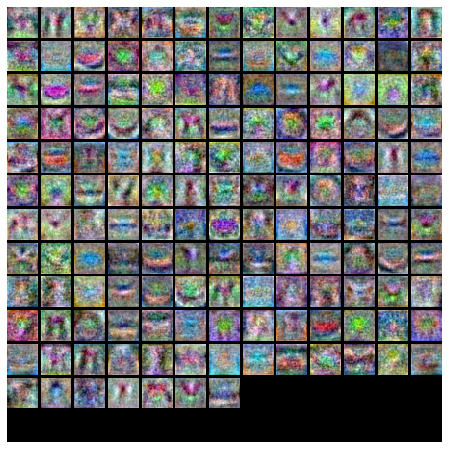

In [8]:
# visualize the weights of the best network
show_net_weights(best_net)

## Тестирование

In [9]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.502
